# Bioremediation of a Coastal Oil Spill: A Case Study Using a Community Genome-Scale Metabolic Model

<img src="https://github.com/Robaina/Robaina/assets/21340147/620a2958-48b3-4b01-8614-4b67c33c167b" alt="Banner image depicting bioremediation" style="width:100%; max-height:200px;">

Oil spills are among the most devastating environmental disasters, posing significant threats to marine ecosystems. In the aftermath of such spills, there is typically a [surge in microbial communities](https://www.frontiersin.org/articles/10.3389/fmicb.2021.633659/full) capable of degrading hydrocarbons found in oil. These communities form complex trophic networks, with different species playing specific roles in the degradation process. By understanding and harnessing the potential of these communities, we can develop effective bioremediation strategies to mitigate the impact of oil spills. Specifically, community metabolic models can be employed to investigate key species and trophic relationships essential for the degradation process. With this knowledge, we can engineer microbial communities, designing [bioaugmentation](https://en.wikipedia.org/wiki/Bioaugmentation) or [biostimulation](https://en.wikipedia.org/wiki/Biostimulation) strategies to enhance bioremediation potential.

In this Jupyter Notebook, we will utilize a community genome-scale metabolic model to explore the trophic network that emerges following a marine coastal oil spill. We will also apply constraint-based modeling techniques, such as [Flux Balance Analysis (FBA)](https://en.wikipedia.org/wiki/Flux_balance_analysis) and [elasticities](https://en.wikipedia.org/wiki/Price_elasticity_of_demand), to identify key taxa and environmental nutrients that could improve the degradation of toxic compounds. Finally, we will develop a biostimulation strategy by adding specific nutrients to the medium, aiming to enhance the bioremediation potential of the community.

## The Community and the Environment

The community under study consists of ten bacterial genera, which are [known to be involved](https://www.frontiersin.org/articles/10.3389/fmicb.2021.633659/full) in the degradation of toluene. The involved genera include:

- *Acinetobacter*
- *Alcanivorax*
- *Alteromonas*
- *Flavobacterium*
- *Marinobacter*
- *Oleibacter*
- *Polaribacter*
- *Pseudomonas*
- *Rhodococcus*
- *Thalassospira*

Our model will simulate a marine medium with three representative carbon sources commonly found in surface waters:

- *Glycogen*, the main storage polymer in cyanobacteria and up to [100 times more abundant](https://ami-journals.onlinelibrary.wiley.com/doi/full/10.1111/1462-2920.14302) than other phytoplankton exudates, such as free monosaccharides or amino acids.
- *Glycinebetaine*, which is [highly abundant](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9321204/) in marine environments.
- *D-Xylulose*, representing the degradation of microalgal polysaccharides.

Additionally, we will include *Toluene*, one of the [most abundant and toxic components](https://www.researchsquare.com/article/rs-3200599/v1) in crude oil, as a representative compound from the oil spill.

## Relevant Tools

For our analysis, we will use the following tools:

* [MICOM](https://github.com/micom-dev/micom): a computational tool for constructing and analyzing community genome-scale metabolic models. It integrates individual metabolic models representing different bacterial genera into a unified community model, enabling the study of metabolic interactions within microbial communities.

* [Cobrapy](https://github.com/opencobra/cobrapy): a Python library for genome-scale metabolic modeling. It offers a straightforward interface for creating, manipulating, and simulating biological networks, essential in systems biology, bioinformatics, and computational biology. Cobrapy is used under the hood by MICOM.

* [NetworkX](https://github.com/networkx): a Python library designed for the creation, manipulation, and analysis of the structure, dynamics, and functions of complex networks. It provides data structures for graphs, graph algorithms, generators, and drawing tools, widely used in various fields such as bioinformatics, social network analysis, and transportation networks.


## Building the Community Model

To construct a community genome-scale model, our first step is to acquire individual genome-scale metabolic models (GEMs) for each bacterial genus within our community. These will then be combined into a unified community model. For this purpose, we will use GEMs from the [MICOM's model database](https://zenodo.org/records/3755182). These GEMs were reconstructed utilizing [CarveMe](https://academic.oup.com/bioinformatics/article/34/17/3038/4999126), a tool designed to reconstruct GEMs from genomes using a universal metabolic model. The representative prokaryotic genomes for each genus were sourced from RefSeq. For your convenience, the individual GEMs used in this notebook are located in the `models` directory.

__NOTE__: In a real-world scenario, it would be possible to reconstruct GEMs directly from metagenome-assembled genomes (MAGs) isolated from the oil spill site.

To construct the community model, we will integrate these individual GEMs into a larger, unified model. This comprehensive model will include a space for shared extracellular metabolites and a community biomass pseudoreaction, in addition to the individual biomass reactions present in each GEM. For this integration, we will use the `build` workflow provided by the Micom toolbox.

MICOM requires a configuration file to execute the `build` workflow. This file specifies the ID and path for each individual GEM. Additionally, MICOM needs a measure of the relative abundance of each community member, as flux predictions for each member are scaled according to their relative abundances, ensuring coherent fluxes across the community. In our study, we will assume equal abundances for all genera. It's worth noting that MICOM also allows for the adjustment of relative abundances post model construction. The configuration file for this notebook can be found in `data/micom_database.tsv`.

In [1]:
import pandas as pd

taxo_df = pd.read_csv("data/micom_database.csv", sep=",", index_col=None)
taxo_df

,sample_id,id,abundance,file
0,oilspill,Acinetobacter,100,models/Acinetobacter.json
1,oilspill,Alcanivorax,100,models/Alcanivorax.json
2,oilspill,Alteromonas,100,models/Alteromonas.json
3,oilspill,Flavobacterium,100,models/Flavobacterium.json
4,oilspill,Marinobacter,100,models/Marinobacter.json
5,oilspill,Oleibacter,100,models/Oleibacter.json
6,oilspill,Polaribacter,100,models/Polaribacter.json
7,oilspill,Pseudomonas,100,models/Pseudomonas.json
8,oilspill,Rhodococcus,100,models/Rhodococcus.json
9,oilspill,Thalassospira,100,models/Thalassospira.json


Let's begin by assembling our community model! The `build` pipeline in Micom will generate a community model, which is saved as a pickle file. This file encapsulates the entire community model, facilitating subsequent analytical processes.

For those who wish to skip the model building phase and dive straight into analysis, we have provided a pre-built community model. You can find this ready-to-use model in the `data` folder, also saved as a pickle file.

In [2]:
from micom.workflows import build

manifest = build(taxonomy=taxo_df, model_db=None, out_folder="results/micom", cutoff=1e-2, threads=14 , solver="gurobi")

[20:21:27] WARNING  Found existing models for 1 samples. Will skip those. Delete the output folder if   ]8;id=930252;file:///home/robaina/miniconda3/envs/phycogem/lib/python3.11/site-packages/micom/workflows/build.py\build.py]8;;\:]8;id=312299;file:///home/robaina/miniconda3/envs/phycogem/lib/python3.11/site-packages/micom/workflows/build.py#95\95]8;;\
                    you would like me to rebuild them.                                                             

Output()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-05


Read LP format model from file /tmp/tmpyz8vjg5s.lp
Reading time = 0.12 seconds
: 15669 rows, 49781 columns, 209395 nonzeros


Now, let's take a closer look at the community model we have just constructed. As illustrated below, the model integrates all 10 individual genome-scale metabolic models (GEMs). It encompasses an impressive aggregate of over 24,800 reactions and more than 15,600 metabolites. Furthermore, MICOM has formulated a community-wide biomass reaction, which serves as the default optimization objective (termed `community_objective`).

In [3]:
from micom import load_pickle

cgem = load_pickle("results/micom/oilspill.pickle")
cgem

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-05
Read LP format model from file /tmp/tmp0lry6exy.lp
Reading time = 0.13 seconds
: 15669 rows, 49781 columns, 209395 nonzeros


Name,oilspill
Memory address,7f8c54562810
Number of metabolites,15658
Number of reactions,24890
Number of genes,11823
Number of groups,0
Objective expression,1.0*community_objective
Compartments,"C_c__Acinetobacter, C_p__Acinetobacter, C_e__Acinetobacter, m, C_c__Alcanivorax, C_e__Alcanivorax, C_p__Alcanivorax, C_c__Alteromonas, C_p__Alteromonas, C_e__Alteromonas, C_e__Flavobacterium, C_p__Flavobacterium, C_c__Flavobacterium, C_c__Marinobacter, C_p__Marinobacter, C_e__Marinobacter, C_c__Oleibacter, C_p__Oleibacter, C_e__Oleibacter, C_c__Polaribacter, C_p__Polaribacter, C_e__Polaribacter, C_c__Pseudomonas, C_p__Pseudomonas, C_e__Pseudomonas, C_c__Rhodococcus, C_p__Rhodococcus, C_e__Rhodococcus, C_c__Thalassospira, C_p__Thalassospira, C_e__Thalassospira"


## Preparing the Medium for the Simulation

We will now prepare the medium used for simulating the oil spill scenario. Specifically, we're employing a marine medium, which includes various salts and essential cofactors like thiamin. As previously mentioned, this medium incorporates three carbon sources typically found in surface waters, along with toluene, representing a common compound in oil spills.

The composition of the medium is detailed in `data/oilspill_medium.tsv`. This file is structured into two columns: the first lists the reaction IDs associated with the exchange reactions in the community model that allow the uptake of specific compounds from the medium. The second column indicates the maximum allowed uptake rate for each compound, measured in mmol/gDW/h. It's important to note that while maximum flux values are positive in this file, the convention in constraint-based modeling is to use negative values for uptake reactions. However, MICOM (and Cobrapy, which it utilizes) automatically adjusts for this convention.

In [4]:
import pandas as pd

medium = pd.read_csv('data/oilspill_medium.tsv', sep='\t', header=None)
medium.columns = ["reaction", "flux"]
medium.set_index('reaction', inplace=False)
medium = medium[medium.reaction.isin([r.id for r in cgem.exchanges])]

## Optimizing Community Growth

With the growth medium established, we're now set to initiate our first simulation. We'll start by maximizing community growth using standard Flux Balance Analysis (FBA). Although optimizing growth is not the primary focus of this Notebook, and isn't required for our analysis, we'll proceed with this step to verify that the model is functioning as expected.

In [5]:
cgem.medium = medium.set_index('reaction').squeeze()
cgem.optimize()

,abundance,growth_rate,reactions,metabolites
compartments,,,,
Acinetobacter,0.1,0.009151,2904,1747
Alcanivorax,0.1,0.000000,2005,1329
Alteromonas,0.1,0.000000,2308,1509
Flavobacterium,0.1,4.195706,2868,1679
Marinobacter,0.1,0.000000,2761,1654
...,...,...,...,...
Polaribacter,0.1,0.000000,1973,1311
Pseudomonas,0.1,0.445514,3277,1869
Rhodococcus,0.1,0.000000,2639,1548


As demonstrated above, the community achieves a maximum growth rate of $0.465 \, h^{-1}$ in this medium. However, it's notable that not all members exhibit positive individual growth rates in the simulation. This outcome stems from using regular FBA, which focuses solely on maximizing the community biomass reaction, disregarding individual growth rates. To remedy this, MICOM offers the cooperative tradeoff algorithm. This approach simultaneously optimizes community and individual growth rates by applying a tradeoff parameter between the two objectives. For comparison purposes, we will employ a tradeoff value of $0.5$.

__NOTE__: Running the `cooperative_tradeoff` can be time-consuming for large models like this one. The following cell can be skipped as these results are not required for the remainder of our analysis.

In [6]:
cgem.cooperative_tradeoff(fraction=0.5)

,abundance,growth_rate,reactions,metabolites
compartments,,,,
Acinetobacter,0.1,0.142397,2904,1747
Alcanivorax,0.1,0.212791,2005,1329
Alteromonas,0.1,0.191224,2308,1509
Flavobacterium,0.1,0.208701,2868,1679
Marinobacter,0.1,0.094519,2761,1654
...,...,...,...,...
Polaribacter,0.1,0.213886,1973,1311
Pseudomonas,0.1,0.112314,3277,1869
Rhodococcus,0.1,0.157577,2639,1548


After running the `cooperative_tradeoff` algorithm, we see that all members have now positive growth rates. However, the community growth rate has decreased to $0.233 \;h^{-1}$. This is expected, because the algorithm is now optimizing both community and individual growth rates, which are competing objectives. In this case, the algorithm has found a tradeoff between the two objectives, which results in a suboptimal, and likely more realistic, community growth rate.

Now that we have checkek that the model is working as expected, let's move on to the analysis of the trophic network.

## Analyzing Trophic Interactions Among Community Members

Our next step is to delve into the metabolic interactions between the various species within our community model. For this purpose, we will utilize MICOM's `grow` workflow. This workflow simulates the growth of the community on different carbon sources in our specified medium, including the pollutant toluene. It employs the cooperative growth algorithm, the same we discussed earlier, with a tradeoff parameter between community and individual growth rates set at $0.5$. The output from this workflow will be a dataframe that details the fluxes through all exchange reactions, thereby sharing metabolites among community members. We will analyze these results to map out the network of trophic interactions within the community, aiming to identify the genera that are directly involved in the uptake and degradation of toluene.

For efficiency, you may choose to bypass the upcoming simulation cell and instead use the pre-computed results available in `results/micom/exchanges.tsv`.

In [7]:
# from micom.workflows import grow

# res = grow(manifest, model_folder="results/micom/", medium=medium, tradeoff=0.5, threads=14)
# res.exchanges[res.exchanges.taxon != 'medium'].to_csv("results/micom/exchanges.tsv", sep="\t")

In [8]:
import pandas as pd

exchanges_df = pd.read_csv("results/micom/exchanges.tsv", sep="\t", index_col=0)
exchanges_df.head()

,taxon,sample_id,tolerance,reaction,flux,abundance,metabolite,direction
5,Acinetobacter,oilspill,0.000001,EX_ile__L_e,-0.040064,0.1,ile__L_e,import
6,Acinetobacter,oilspill,0.000001,EX_arab__L_e,100.000000,0.1,arab__L_e,export
10,Acinetobacter,oilspill,0.000001,EX_ala__L_e,49.279159,0.1,ala__L_e,export
12,Acinetobacter,oilspill,0.000001,EX_id3acald_e,-50.696825,0.1,id3acald_e,import
13,Acinetobacter,oilspill,0.000001,EX_h_e,15.863993,0.1,h_e,export


The results we have obtained clearly indicate the presence of trophic interactions among the community members. The table presented above enumerates the compounds being exchanged within the community. In the `reaction` field, each entry corresponds to an exchange reaction that either imports a compound from or exports it to the medium. The `flux` field indicates the direction of this exchange, with negative values representing import and positive values representing export. Additionally, the `taxon` field identifies which community member is responsible for importing or exporting each compound.

It's important to note that this table includes all compounds present in the medium. This encompasses not only the original compounds that served as starting points for community growth but also new compounds synthesized and excreted by the community members.

By examining the table, we can figure out which community members are able to uptake `toluene` from the enviroment. Specifically, reaction `EX_tol_e` should display a negative flux value, since negative flux values denote imports:

In [9]:
toluene_uptakers = exchanges_df[(exchanges_df['reaction'] == 'EX_tol_e') & (exchanges_df['flux'] < 0)]
toluene_uptakers

,taxon,sample_id,tolerance,reaction,flux,abundance,metabolite,direction
249,Acinetobacter,oilspill,0.000001,EX_tol_e,-0.000204,0.1,tol_e,import


According to the results above, `Acinetobacter` is the only member able to uptake toluene from the environment. Let's next visualize the trophic relations with a network graph

### Representing the Trophic Network as a Bipartite Graph

To facilitate our analysis, we will now represent these trophic relationships in the form of a bipartite graph. In this graph, the nodes are designated either as compounds or community members, while the edges symbolize the trophic interactions between them. We'll employ the `networkx` library to both construct and visualize this graph. For the sake of simplicity in our visualization, we will focus on a selected subset of taxa as well as a subset of all excreted compounds, excluding most inorganic compounds. However, note that this is just for the visualization, the full set of taxa and compounds is used throughout the analysis in this notebook. You may change the selected taxa to dsiplay in the graph by updating the `selected_taxa` variable in the cell below.

In [10]:
from src.helper_functions import (
    generate_bipartite_graph,
    get_donor_receiver_from_exchanges,
    get_used_medium_sources
    )

selected_taxa = [
    "Acinetobacter", "Pseudomonas", "Alteromonas",
    "Thalassospira", "Marinobacter"
]

hidden_metabolites = [
    'h', 'h2', 'btn', 'ca2', 'cl', 'co2',
    'cu2', 'fe2', 'fe3', 'k', 'no2', 'no3',
    'so4', 'thm', 'zn2', 'pi', 'h2o', 'o2',
    'cobalt2', 'nh4', 'hco3', 'mg2', 'mn2'
    ]

# Prepare bipartite graph
donor_receiver_df = get_donor_receiver_from_exchanges(exchanges_df)
donor_receiver_df.loc[:, "compound"] = donor_receiver_df[
    "compound"
    ].str.replace("glycogen1500_m", "glycog_m") # Simplify glycogen ID
used_medium_sources = get_used_medium_sources(donor_receiver_df)

exchanges_file_path = "results/micom/exchanges.tsv"
all_taxa = taxo_df["id"].tolist()
hidden_taxa = [taxon for taxon in all_taxa if taxon not in selected_taxa]

bipartite_graph = generate_bipartite_graph(
    exchanges_file_path,
    hide_taxa=hidden_taxa,
    hide_metabolites=hidden_metabolites,
    keep_metabolites=["bz"],
    flux_cutoff=0.0,
    target_taxon="Acinetobacter",
    environmental_carbon_sources=used_medium_sources,
    relabel_nodes={"glycogen1500": "glycog"},
    output_graph="results/micom/bipartite_graph.json",
    )

### Plotting the Trophic Network

Our final step involves using `networkx` to plot the bipartite graph we previously generated. For this visualization, we'll adopt a shell layout, where the two classes of nodes – compounds and taxa – are arranged in two concentric circles. The nodes representing compounds will be positioned on the external circle, while those representing taxa will be located on the internal circle. This arrangement is chosen to enhance the visibility and clarity of the edges connecting the nodes.

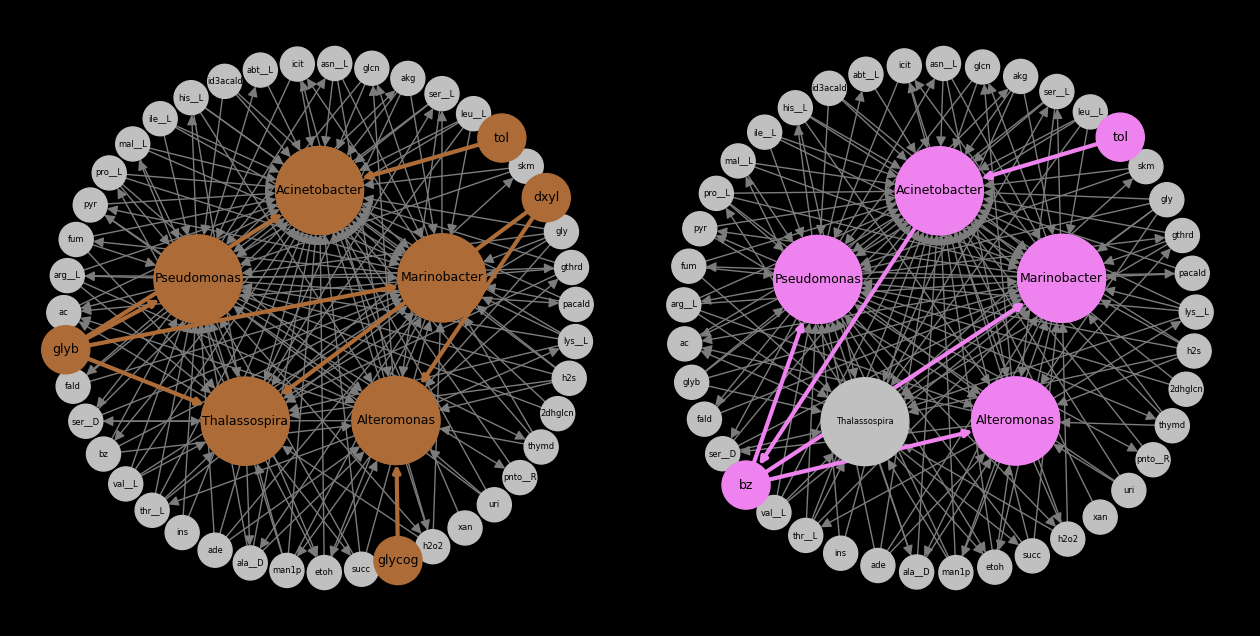

In [30]:
from matplotlib import pyplot as plt
from src.helper_functions import plot_trophic_interactions

environmental_carbon_sources = used_medium_sources
color_other_edges = '#7c7c7c'
color_other_nodes = 'silver'
target_taxon = 'Acinetobacter'
large_node_size = 4000
small_node_size = 600
edge_width_target_taxon = 3.0
edge_width_other = 1.0
arrow_size_target_taxon = 10
arrow_size_other = 15
font_size = 6
seed = 82

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
plot_trophic_interactions(
    bipartite_graph=bipartite_graph,
    environmental_carbon_sources=environmental_carbon_sources,
    ax=axs[0],
    highlight_compounds=["glycog", "dxyl", "glyb", "tol"],
    target_taxon=target_taxon,
    color_oil_nodes='#ad6c37',
    color_other_edges=color_other_edges,
    color_other_nodes=color_other_nodes,
    large_node_size=large_node_size,
    small_node_size=small_node_size,
    edge_width_target_taxon=edge_width_target_taxon,
    edge_width_other=edge_width_other,
    arrow_size_target_taxon=arrow_size_target_taxon,
    arrow_size_other=arrow_size_other,
    font_size=font_size,
    seed=seed
)
plot_trophic_interactions(
    bipartite_graph=bipartite_graph,
    environmental_carbon_sources=environmental_carbon_sources,
    ax=axs[1],
    highlight_compounds=["tol", "bz"],
    target_taxon=target_taxon,
    color_oil_nodes='violet',
    color_other_edges=color_other_edges,
    color_other_nodes=color_other_nodes,
    large_node_size=large_node_size,
    small_node_size=small_node_size,
    edge_width_target_taxon=edge_width_target_taxon,
    edge_width_other=edge_width_other,
    arrow_size_target_taxon=arrow_size_target_taxon,
    arrow_size_other=arrow_size_other,
    font_size=font_size,
    seed=seed
)

fig.set_facecolor("black")
plt.subplots_adjust(wspace=0, hspace=0) 
plt.show()

The figures above reveal a complex trophic network in our community model. The first graph shows the processing of external carbon sources (colored brown: Glycogen, D-Xylulose, Glycinebetaine, and Toluene). The community also generates and exchanges a variety of organic compounds (gray nodes), crucial for collective growth and aiding in toluene degradation.

The second graph focuses on Toluene degradation. _Acinetobacter_ consumes Toluene, converting it into Benzoate, which is then further degraded into non-toxic substances by _Pseudomonas_, _Marinobacter_, and _Alteromonas_. _Thalassospira_, while not directly involved in Toluene degradation, supports the process by producing compounds used by _Acinetobacter_.

For a detailed look at specific interactions, we can examine the exchanges involving _Acinetobacter_. A specialized function filters the original exchanges dataframe to highlight these interactions, offering insights into the compounds imported by _Acinetobacter_ and the community members supporting its growth.

In [12]:
from src.helper_functions import get_shared_metabolites_for_taxon

acinetobacter_imports = get_shared_metabolites_for_taxon(exchanges_df, 'Acinetobacter')
acinetobacter_imports.to_csv('results/micom/acinetobacter_imports.tsv', sep='\t')
acinetobacter_imports.nsmallest(15, 'flux_import')

,metabolite,taxon_import,flux_import,taxon_export,flux_export
35,ser__D_e,Acinetobacter,-100.0,Flavobacterium,99.898370
24,glcn_e,Acinetobacter,-100.0,Alteromonas,100.000000
25,glcn_e,Acinetobacter,-100.0,Rhodococcus,99.456212
82,etoh_e,Acinetobacter,-100.0,Pseudomonas,12.175346
27,icit_e,Acinetobacter,-100.0,Flavobacterium,197.770173
28,icit_e,Acinetobacter,-100.0,Marinobacter,68.872346
29,icit_e,Acinetobacter,-100.0,Alteromonas,10.559273
30,icit_e,Acinetobacter,-100.0,Rhodococcus,6.609377
81,etoh_e,Acinetobacter,-100.0,Marinobacter,5.134605
23,glcn_e,Acinetobacter,-100.0,Marinobacter,100.000000


We have printed the first 15 exchanges with the largest import flux value by _Acinetobacter_, but you can find the complete list in `results/micom/acinetobacter_exchanges.tsv`. As we already saw in the bipartite graph, _Acinetobacter_'s growth is supported by a variety of compounds produced by the rest of the community members, which indirectly contribute to the degradation of toluene.

## Identifying Key Metabolites and Taxa for Toluene Degradation Through Elasticities

`Elasticities` provide a quantitative measure to evaluate how metabolic reactions respond to changes in nutrient uptake rates and relative abundances of taxa in the community. For simplicity, we'll use the term _effector_ to denote both. Elasticities are mathematically defined as:

$$
\varepsilon_p^v = \frac{\partial v}{\partial p}\frac{p}{v} = \frac{\partial\ln v}{\partial\ln p}
$$

Here, $\varepsilon_p^v$ is the elasticity of a reaction rate $v$ to a change in the effector $p$. A negative elasticity implies that the reaction rate decreases as the effector increases, and vice versa for positive elasticity.

Analyzing these elasticities helps identify key metabolites or taxa that serve as control points in the metabolic network, influencing biochemical pathway fluxes. This understanding enables targeted strategies for modifying community behavior.

Focusing on exchange reactions and taxa abundances as effectors, we will use MICOM's `elasticities` workflow to calculate the elasticities of all exchange reactions for each effector. The resulting dataframe will list these elasticities, guiding us to identify the most responsive factors for toluene uptake. This information is crucial for developing strategies to enhance the community's bioremediation potential.

__NOTE__: Running this calculation can be time-consuming. You can opt to use pre-computed results available in `results/micom/elasticities.tsv`. If you still want to run the cell, please, first convert it to a `code` cell.

```python
from micom.elasticity import elasticities

eps = elasticities(cgem, fraction=0.5, reactions=cgem.exchanges)
eps.to_csv("results/micom/elasticities.tsv", sep="\t", index=False)
```

In [13]:
elasticities_df = pd.read_csv('results/micom/elasticities.tsv', sep='\t', index_col=0)
elasticities_df.head()

,taxon,effector,direction,elasticity,type
reaction,,,,,
EX_glc__D_m,medium,EX_h_m,zero,0.00000,exchanges
EX_h2o_m,medium,EX_h_m,reverse,-18.63519,exchanges
EX_14glucan_m,medium,EX_h_m,zero,0.00000,exchanges
EX_h_m,medium,EX_h_m,reverse,1.00000,exchanges
EX_2pglyc_m,medium,EX_h_m,zero,0.00000,exchanges


The elasticity analysis results table offers insights into the responsiveness of specific reactions within the microbial community to changes in metabolite concentrations. The table's _Reaction_ column identifies the biochemical reactions, and _Taxon_ specifies the associated microbe or environmental medium. _Effector_ denotes the metabolite influencing the reaction rate, while 'Direction' indicates whether the reaction rate increases, decreases, or remains unchanged with changes in effector concentration. The _Elasticity_ value quantifies this responsiveness, with higher values signifying greater sensitivity.

### Assessing Taxa Influence on Toluene Degradation

Using our previously calculated elasticities, we can now analyze how changes in the abundance of specific taxa affect the community's toluene uptake. By focusing on elasticity values tied to toluene uptake, we can pinpoint which microorganisms significantly impact this process. Positive elasticity indicates that increasing a taxon's abundance enhances toluene uptake, whereas negative values suggest a reduction. This analysis is key to understanding each species' role in toluene metabolism and may inform the engineering of microbial communities for enhanced bioremediation or bioaugmentation.

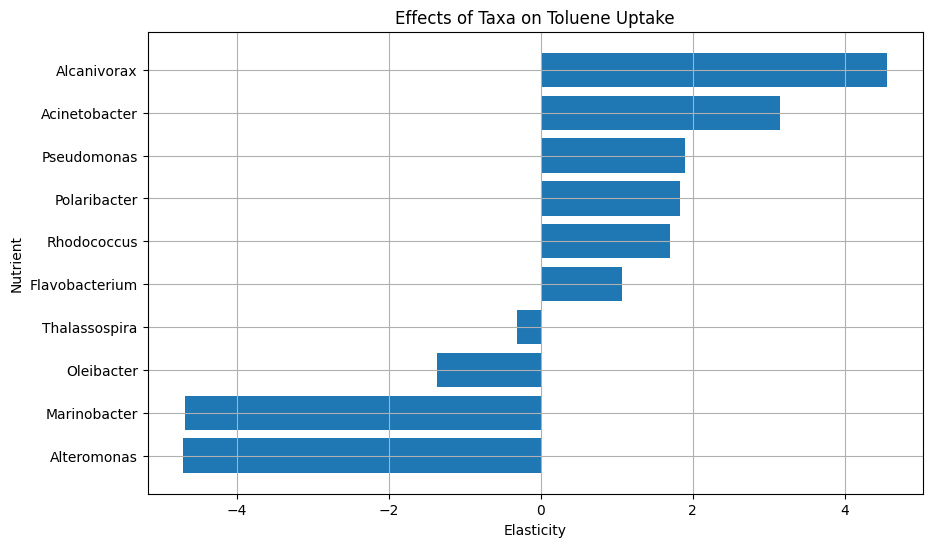

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

elasticities_df = pd.read_csv('results/micom/elasticities.tsv', sep='\t')
toluene_intake_taxa_effects = elasticities_df[
    (elasticities_df['reaction'] == 'EX_tol_m') &
    (elasticities_df['direction'] == 'reverse') & 
    (elasticities_df['type'] == 'abundance')
    ]
toluene_intake_taxa_effects = toluene_intake_taxa_effects.sort_values(by='elasticity', ascending=True)
taxa = toluene_intake_taxa_effects['effector']
elasticities = toluene_intake_taxa_effects['elasticity']

plt.figure(figsize=(10, 6))
plt.barh(taxa, elasticities)
plt.xlabel('Elasticity')
plt.ylabel('Nutrient')
plt.title('Effects of Taxa on Toluene Uptake')
plt.grid(True)
plt.show()

The analysis of toluene intake effects reveals the impact of increasing each taxon's abundance on toluene uptake by _Acinetobacter_. Remember that in exchange reactions, the uptake of a compound typically corresponds to negative flux values. A positive elasticity value suggests a direct correlation between a taxon's abundance and increased toluene uptake, while a negative value indicates an inverse relationship.

Most taxa positively affect toluene uptake by _Acinetobacter_, likely due to the beneficial metabolites they release, which support _Acinetobacter_'s growth. However, some, like _Alternomonas_ and _Marinobacter_, show a negative impact, possibly due to substrate competition with _Acinetobacter_.

This elasticity analysis is insightful, quickly identifying taxa that either aid or hinder toluene uptake. With these findings, we can devise strategies to optimize toluene bioremediation. For instance, we might reduce a competing taxon through targeted methods (e.g., a taxon-specific virus) or by altering environmental conditions to disadvantage them.


### Biostimulation: Analyzing the Effects of External Nutrients on Toluene Degradation

Alongside the impact of different taxa, the role of external nutrients in toluene uptake is another crucial aspect. This analysis helps understand how nutrients affect the community's metabolism and identifies ways to modulate toluene uptake. By pinpointing nutrients that enhance toluene uptake by _Acinetobacter_, we can optimize bioremediation in oil spills through biostimulation.

Nutrients with negative elasticity values are key: the more negative the elasticity, the greater the nutrient's impact on boosting toluene uptake by _Acinetobacter_. Identifying nutrients with significant negative elasticity allows us to consider their addition to the environment as a biostimulation strategy, enhancing toluene bioremediation.

However, the potential side effects on the ecosystem must be cautiously weighed. The introduction of these nutrients might influence other ecological processes and organisms. Thus, biostimulation strategies require careful planning and monitoring to ensure they are effective and do not inadvertently cause harm.

Next, we will visualize the elasticity values of all original environmental nutrients in relation to toluene uptake by _Acinetobacter_.

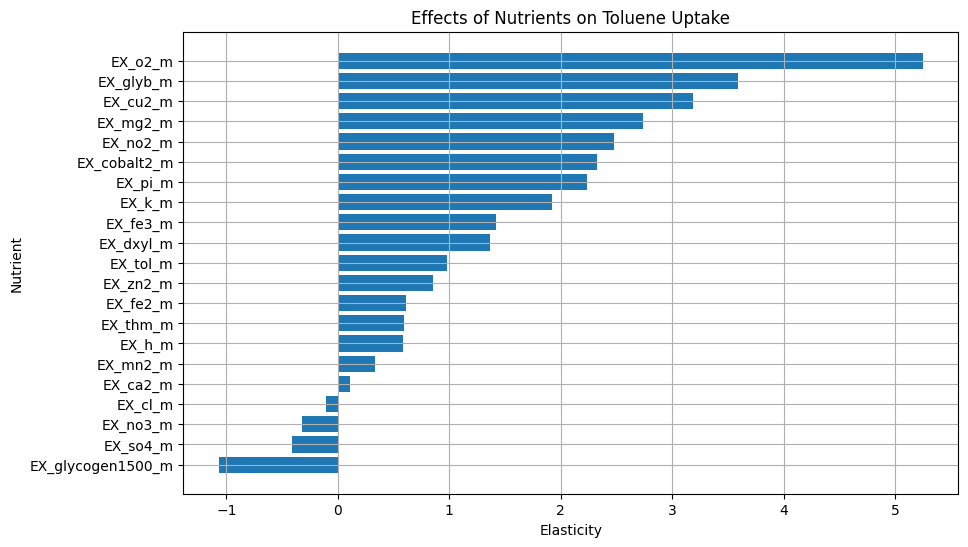

In [15]:
import matplotlib.pyplot as plt

toluene_intake_nutrient_effects = elasticities_df[
    (elasticities_df['reaction'] == 'EX_tol_m') &
    (elasticities_df['direction'] == 'reverse') & 
    (elasticities_df['type'] == 'exchanges')
    ]
toluene_intake_nutrient_effects = toluene_intake_nutrient_effects.sort_values(by='elasticity', ascending=True)
nutrients = toluene_intake_nutrient_effects['effector']
elasticities = toluene_intake_nutrient_effects['elasticity']

plt.figure(figsize=(10, 6))
plt.barh(nutrients, elasticities)
plt.xlabel('Elasticity')
plt.ylabel('Nutrient')
plt.title('Effects of Nutrients on Toluene Uptake')
plt.grid(True)
plt.show()

From the analysis, it's evident that most nutrients positively influence toluene uptake, with notable exceptions like chloride (Cl), nitrate (NO3), sulphate (SO4), and glycogen. Intriguingly, glycogen seems to negatively affect toluene uptake, possibly due to competition between carbon sources. This insight opens the door to biostimulation experiments targeting nutrients that significantly boost _Acinetobacter_'s toluene uptake.

However, the potential ecological impacts of introducing these nutrients must be carefully evaluated. Fortunately, we can simulate biostimulation _in silico_ by increasing the maximum uptake rates of nutrients with positive elasticity values. Let's proceed with this simulation in the next step.

## Increasing Toluene Uptake Through Biostimulation

Having identified nutrients that could boost toluene bioremediation, we're now set to devise a biostimulation strategy to enhance _Acinetobacter_'s toluene uptake. We'll focus on increasing the uptake rate of the top five impactful nutrients (excluding $O_2$): `Glycinebetaine` (glyb), `Copper` (cu2), `Magnesium` (Mg2+), `Nitrite` (no2), and `Cobalt` (cobalt2). By simulating community growth in this nutrient-enriched medium, we can compare the toluene uptake rates against those from the original scenario.

In [16]:
# Find n largest nutrient effectors
n = 6
largest_nutrient_effectors = toluene_intake_nutrient_effects.nlargest(n, 'elasticity').effector.to_list()
largest_nutrient_effectors

['EX_o2_m', 'EX_glyb_m', 'EX_cu2_m', 'EX_mg2_m', 'EX_no2_m', 'EX_cobalt2_m']

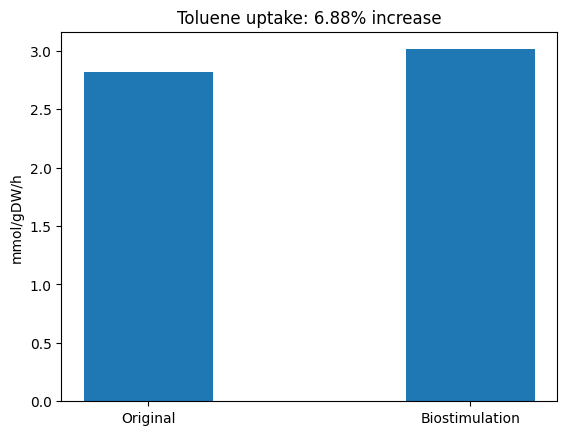

In [17]:
import matplotlib.pyplot as plt

# Reset medium
cgem.medium = medium.set_index('reaction').squeeze()
cgem.optimize()

# Simulate additon of nutrients to increase toluene uptake
toluene_uptake = cgem.reactions.get_by_id('EX_tol_m')
old_toluene_uptake_rate = toluene_uptake.flux

# Open exchanges of selected nutrients
selected_nutrients = largest_nutrient_effectors[1:]
for rxn_id in selected_nutrients:
    cgem.reactions.get_by_id(rxn_id).bounds = (-1000, 1000)

# Update optimization
cgem.optimize()
new_toluene_uptake_rate = toluene_uptake.flux

# Plot uptake changes
pct_change = round((new_toluene_uptake_rate - old_toluene_uptake_rate) / old_toluene_uptake_rate * 100, 2)
plt.bar(['Original', 'Biostimulation'], [-old_toluene_uptake_rate, -new_toluene_uptake_rate], width=0.4)
plt.ylabel('mmol/gDW/h')
plt.title(f'Toluene uptake: {pct_change}% increase')
plt.show()

After the simulated biostimulation strategy, toluene uptake has increased by 7% compared to the original community. This is a significant increase, and shows that biostimulation can be a powerful tool for enhancing the bioremediation of oil spills by increasing the uptake of toxic compounds by microbial communities.

## Conclusions

In this notebook, we've utilized a community genome-scale metabolic model to explore the trophic network formed after a marine coastal oil spill. Employing constraint-based modeling techniques such as Flux Balance Analysis (FBA) and the calculation of elasticities, we've identified crucial taxa and environmental nutrients that can enhance the degradation of toxic compounds. Leveraging this knowledge, we've developed a biostimulation strategy, adding specific nutrients to the medium to boost the community's bioremediation potential.